# Oceanic Whirlpool Trajectory Prediction using AnDa

## Useful imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as pat
from scipy.linalg import sqrtm
from numpy import linalg as LA
from numpy.linalg import det
from numpy.linalg import inv
from sklearn.metrics import mean_squared_error

## Function definitions

In [12]:
#Turn ellipse into multivariate 2D Gaussian.
###############################################################################################################

def ellipseToGaussian(x_center,y_center,r_xi,r_eta,alpha_rad):
    """ Transforme les ellipses en gaussiennes
    Prend des arrays de taille N en argument, renvoie un array de taille Nx5"""
    mux= x_center
    muy = y_center 
    sigma_xi = (1/6)*r_xi
    sigma_eta = (1/6)*r_eta
    
    #CovMat = np.diag([[sigma_eta**2, 0],[0, sigma_xi**2]])
    l1 = np.vstack([sigma_eta**2, np.zeros(sigma_xi.shape[0])]).T
    l2 = np.vstack([np.zeros(sigma_eta.shape[0]), sigma_xi**2]).T
    CovMat = np.concatenate([l1, l2], axis=1).reshape((l1.shape[0], 2, 2))
    
    P = np.array([[np.cos(alpha_rad+(np.pi/2)), np.sin(alpha_rad+(np.pi/2))],[-np.sin(alpha_rad+(np.pi/2)), np.cos(alpha_rad+(np.pi/2))]])
    P = np.moveaxis(P, (0,1,2), (1,2,0))
    P_1 = np.linalg.inv(P)
    CovMatBis = P_1 @ CovMat @ P
    return np.vstack([mux, muy, CovMatBis[:,0,0], CovMatBis[:,0,1], CovMatBis[:,1,1]]).T

#Metrics
###############################################################################################################
def wasserstein_metric(mu1,mu2,covMat1,covMat2):
    rC2 = sqrtm(covMat2)
    mat = covMat1 + covMat2 - (2*sqrtm(np.linalg.multi_dot([rC2, covMat1, rC2])))   
    wasserstein = np.linalg.norm(mu1-mu2)**2 + np.trace(mat)
    return wasserstein

def hellinger_metric(mu1,mu2,covMat1,covMat2):
    coef = (np.linalg.det(covMat1)**(1/4))*(np.linalg.det(covMat2)**(1/4))/(np.linalg.det(0.5*(covMat1+covMat2)))
    exp_ = np.linalg.multi_dot([np.transpose(mu1-mu2),0.5*(covMat1+covMat2),mu1-mu2])
    hellinger = 1-(coef*np.exp((-1/8)*exp_))
    return hellinger

def KL_div(mu1,mu2,covMat1,covMat2):
    prod = np.linalg.multi_dot([np.transpose(mu2-mu1),np.linalg.inv(covMat2),mu2-mu1])
    tr = np.trace(np.dot(np.linalg.inv(covMat2),covMat1))
    kl = 0.5*(tr + prod - 2 + np.log(np.linalg.det(covMat2)/np.linalg.det(covMat1)))
    return kl

#Utilities for playground and data generation
###############################################################################################################

def gaus2d(pos,mean, covMat):
    """calcule la valeur de la gaussienne à un point pos"""
    return 1. / (2. * np.pi * np.sqrt(det(covMat))) * np.exp(-0.5 * np.dot(np.dot((pos-mean).T,inv(covMat)),pos-mean))

def sum_gaus2d(pos,list_mean,list_covMat):
    """renvoie la valeur pour l'ensemble des gaussiennes à un point pos"""
    res = 0
    for i in range(len(list_mean)):
        if(i%2==0):
            res += gaus2d(pos,list_mean[i],list_covMat[i])
        else:
            res -= gaus2d(pos,list_mean[i],list_covMat[i])
    return res

def gradient_gauss2d(pos,mean,covMat):
    """calcule le gradient de la gaussienne à un point pos"""
    return np.dot(inv(covMat),pos-mean)*gaus2d(pos,mean,covMat)

def sum_gradient_gauss2d(pos,list_mean,list_covMat):
    """calcule la somme des gradient pour l'ensemble des gaussiennes à un point pos"""
    dire = np.array([0.0,0.0])
    for i in range(len(list_mean)):
        if(i%2==0):
            dire += gradient_gauss2d(pos,list_mean[i],list_covMat[i])
        else:
            dire -= gradient_gauss2d(pos,list_mean[i],list_covMat[i])
    dire = np.array([-dire[1],dire[0]])
    return dire

def direction(mean,center_ref,bruit = 0.2):
    """renvoie la direction à suivre pour arriver au centre"""
    dire = center_ref-mean
    dire = dire/LA.norm(dire, axis=1)[:,np.newaxis]
    dire += np.random.randn(mean.shape[0],2) * bruit
    return dire
    
def vitesse(covMat):
    """renvoie la vitesse du tourbillon"""
    u, s, vh = np.linalg.svd(covMat)
    return s[:,0]**0.5 + s[:,1]**0.5

def converge_center(tourbillons,center,bruit = 0.2):
    """renvoie la nouvelle position du tourbillon, le tourbillon va se diriger vers center"""
    mean = tourbillons[:,:2]
    covMat = np.insert(tourbillons[:,2:], 2, tourbillons[:,3]).reshape((-1,2,2))
    dire = direction(mean,center,bruit = bruit)
    vit = vitesse(covMat)
    return np.concatenate([mean + (vit[:,np.newaxis] * dire), tourbillons[:,2:]], axis=1)

def spiral(tourbillons,bruit = 0.2,alpha = 30):
    """renvoie la nouvelle position du tourbillon, le tourbillon va faire une rotation d'alpha ou une spirale"""
    mean = tourbillons[:,:2]
    CovMat = np.insert(tourbillons[:,2:], 2, tourbillons[:,3]).reshape((-1,2,2))
    theta = np.radians(alpha)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c))).reshape((-1,2,2))
    dire = direction(mean, np.dot(R, mean.T).reshape((-1,2)),bruit=bruit)
    vit = vitesse(CovMat)
    return np.concatenate([mean + (vit[:,np.newaxis] * dire), tourbillons[:,2:]], axis=1)

def follow_gradient(tourbillon,list_mean_gauss,list_covMat_gauss,bruit = 0.2):
    mean = tourbillon[:2]
    covMat = np.insert(tourbillon[2:], 2, tourbillon[3]).reshape((-1,2,2))
    dire = sum_gradient_gauss2d(mean,list_mean_gauss,list_covMat_gauss)
    dire = dire/LA.norm(dire)
    dire += np.random.randn(2) * bruit
    vit = vitesse(covMat)

    return np.concatenate((mean + (vit * dire),tourbillon[2:]))

def generer_ellipses(N):
    """génère N ellipses, renvoie un array de taille Nx5"""
    x_center = 7*np.random.random_sample(N) + 1
    y_center = 7*np.random.random_sample(N) + 1 
    r_xi = np.random.lognormal(0,1/7,N)
    r_eta = np.random.lognormal(0,1/7,N)
    alpha = np.random.rand(N)*360
    alpha_rad = np.radians(alpha)
    return np.vstack([x_center, y_center, r_xi, r_eta, alpha_rad]).T

def step(tourbillons, bruit=0.2, center=None, alpha=None, model="follow gradient"):
    """Calcule le prochain état des tourbillons
    tourbillons de taille Nx5"""
    global list_mean_gauss
    global list_covMat_gauss
    if model == "spiral":
        next_tourbillons = spiral(tourbillons, bruit=bruit, alpha=alpha)
    elif model == "centre":
        next_tourbillons = converge_center(tourbillons, bruit=bruit, center=center)
    elif model == "follow gradient":
        next_tourbillons = []
        for tourbillon in tourbillons:
            next_tourbillons.append(follow_gradient(tourbillon, list_mean_gauss, list_covMat_gauss, bruit=bruit))
    return next_tourbillons

def generer_catalogue(N, bruit=0.2, center=None, alpha=None, model="follow gradient"):
    """ Le catalogue est un array de taille Nx2x10 : nb de tourbillons x (anologues,successeurs) x nb de paramètres
    renvoie un catalogue de taille Nx2x10"""
    catalogue = np.empty((N,2,10))
    ellipses = generer_ellipses(N)
    gaussians = ellipseToGaussian(ellipses[:,0], ellipses[:,1], ellipses[:,2], ellipses[:,3], ellipses[:,4]) # taille Nx5
    next_gaussians = step(gaussians, bruit=bruit, center=center, alpha=alpha, model=model)
    next2_gaussians = step(next_gaussians, bruit=bruit, center=center, alpha=alpha, model=model)
    catalogue[:,0,:5] = gaussians
    catalogue[:,0,5:] = next_gaussians
    catalogue[:,1,:5] = next_gaussians
    catalogue[:,1,5:] = next2_gaussians
    return catalogue

def playground():
    list_mean = []
    list_covMat = []
    while len(list_mean)<6:
        mean = np.random.randint(2.5,7.5, size=2)
        line_cov = np.random.randint(-10,10, size=3)
        covMat = np.array([[line_cov[0],line_cov[1]],[line_cov[1],line_cov[2]]])
        if(det(covMat)>0 and line_cov[0]>0):
            list_mean.append(mean)
            list_covMat.append(covMat)

    precision = 100
    X = np.linspace(0, 10, precision)
    Y = np.linspace(0, 10 , precision)
    Z = np.empty((precision,precision))
    for i in range(len(X)):
        for j in range(len(Y)):
            pos = np.array([X[i],Y[j]])
            Z[i][j] = sum_gaus2d(pos,list_mean,list_covMat)
    return list_mean, list_covMat, X, Y, Z

def load_playground():
    npzfile = np.load("playground_file.npz")
    list_mean_gauss = npzfile['list_mean_gauss']
    list_covMat_gauss = npzfile['list_covMat_gauss']
    X = npzfile['X']
    Y = npzfile['Y']
    Z = npzfile['Z'].T
    return list_mean_gauss, list_covMat_gauss, X, Y, Z

def load_data(filename ='catalogue.txt'):
    data = np.loadtxt(filename)
    data = data.reshape((int(data.shape[0]/2),2,10))
    return data

#Plot
###############################################################################################################

def plot_tourbillon(tourbillon):
    # returns a matplotlib patch
    # tourbillon de taille 5
    mean = tourbillon[:2]
    C = np.insert(tourbillon[2:], 2, tourbillon[3]).reshape((2,2))
    u, s, vh = np.linalg.svd(C)
    theta = np.sign(C[1,0]) * np.arccos(np.trace(C)/2)
    a = pat.Ellipse(xy=mean, width=6*s[0]**0.5, height=6*s[1]**0.5, angle=theta*180/np.pi)
    return a

#Prediction utilities
###############################################################################################################

def wasserstein_vect(u,v):
    """u,v de taille Nx5"""
    mean_u = u[:,:2]
    cov_u = np.insert(u[:,2:], 2, u[:,3]).reshape((-1,2,2))
    mean_v = v[:,:2]
    cov_v = np.insert(v[:,2:], 2, v[:,3]).reshape((-1,2,2))
    
    return np.array([wasserstein_metric(mean_u[i,:],mean_v[i,:],cov_u[i,:],cov_v[i,:]) for i in range(mean_u.shape[0])])

def new_wasserstein(u, v):
    """u,v de taille Nx10"""
    return wasserstein_vect(u[:,:5], v[:,:5]) + wasserstein_vect(u[:,5:], v[:,5:])

def gaussian_kernel(u, v, l=1.):
    return np.exp(-np.square(new_wasserstein(u, v))/l**2)

def compute_weights(x, neighbors, **args):
    kernels = gaussian_kernel(np.repeat(x[np.newaxis,...], neighbors.shape[0], axis=0), neighbors, **args)
    return kernels / np.sum(kernels)

def locally_constant_mean(x, neighbors, successors, weights):
    return np.sum(successors * weights.reshape((-1,1)), axis=0)

def locally_incremental_mean(x, neighbors, successors, weights):
    return x + np.sum((successors - neighbors) * weights.reshape((-1,1)), axis=0)

def locally_linear_mean(x, neighbors, successors, weights):
    W = np.diag(weights)
    X = neighbors
    Y = successors
    X_mean = np.sum(X*weights.reshape((-1,1)), axis=0)
    Y_mean = np.sum(Y*weights.reshape((-1,1)), axis=0)
    X_centered = X - X_mean
    Y_centered = Y - Y_mean
    cov_X = X_centered.T @ W @ X_centered
    cov_X_inv = np.linalg.pinv(cov_X, rcond=0.01)
    cov_YX = Y_centered.T @ W @ X_centered
    return Y_mean + cov_YX @ cov_X_inv @ (x - X_mean)

def predictions(nb_predictions, catalogue_obs, method, num_tourbillon):
    global catalogue
    tourbillons_suivant=[]
    position_tourbillons_suivant=[]
    current_obs = catalogue_obs[num_tourbillon,0,:]

    for k in range(nb_predictions):
        ellipse_obs_t_1 = current_obs[:5]
        ellipse_obs_t = current_obs[5:]

        mean_obs_t_1 = ellipse_obs_t_1[:2]
        mean_obs_t = ellipse_obs_t[:2]
        covMatobsT_1 = np.insert(ellipse_obs_t_1[2:], 2, ellipse_obs_t_1[3]).reshape((2,2))
        covMatobsT = np.insert(ellipse_obs_t[2:], 2, ellipse_obs_t[3]).reshape((2,2))

        distances_wt = []
        for i in range(catalogue.shape[0]):
            ellipse_t_1 = catalogue[i,0,:5]
            ellipse_t = catalogue[i,0,5:]
            mean_t_1 = ellipse_t_1[:2]
            covMatT_1 = np.insert(ellipse_t_1[2:], 2, ellipse_t_1[3]).reshape((2,2))
            mean_t = ellipse_t[:2]
            covMatT = np.insert(ellipse_t[2:], 2, ellipse_t[3]).reshape((2,2))
            distance_wt = wasserstein_metric(mean_obs_t_1,mean_t_1,covMatobsT_1,covMatT_1) + wasserstein_metric(mean_obs_t,mean_t,covMatobsT,covMatT)
            distances_wt.append(distance_wt)
        k=100
        indices_wt=[]
        distances_wt2 = np.array(distances_wt[:])

        for i in range(k):
            indice_wt = distances_wt.index(min(distances_wt))
            indices_wt.append(indice_wt)
            distances_wt[indice_wt] = np.inf

        neighbors = catalogue[indices_wt,0,:]
        successors = catalogue[indices_wt,1,:]
        x = current_obs
        l = np.median(distances_wt2[indices_wt])
        kernels = np.exp(-np.square(distances_wt2[indices_wt])/l**2)
        weights = kernels / np.sum(kernels)


        pred = method(x, neighbors, successors, weights)
        tourbillons_suivant.append(plot_tourbillon(pred[5:]))
        position_tourbillons_suivant.append(pred[5:][:2])
        current_obs = np.concatenate((current_obs[5:],pred[5:]))
    return tourbillons_suivant, position_tourbillons_suivant

def list_prediction(nb_predictions, catalogue_obs, method):
    """construit une matrice de taille nombre d'ellipses x nb_predictions x 2 (coordonnées en x et y)
    cette matrice représente les valeurs prédites"""
    mat_prediction = np.empty((catalogue_obs.shape[0],nb_predictions,2))
    for i in range(catalogue_obs.shape[0]):
        _, position_tourbillons_suivant = predictions(nb_predictions, catalogue_obs, method, i)
        for j in range(nb_predictions):
            mat_prediction[i][j] = np.array(position_tourbillons_suivant[j])
    return mat_prediction

def list_true_value(nb_predictions,catalogue_obs,bruit=0.2,center=None,alpha=None,model="follow gradient"):
    """construit une matrice de taille nombre d'ellipses x nb_predictions x 2 (coordonnées en x et y)
    cette matrice représente les valeurs réelles si les tourbillons suivent le modèle prédéfini"""
    mat_true = np.empty((catalogue_obs.shape[0],nb_predictions,2))
    next_gaussians = catalogue_obs[:,0,5:]
    for j in range(nb_predictions):        
        next_gaussians = step(next_gaussians, bruit=bruit, center=center, alpha=alpha, model=model)
        for i in range(catalogue_obs.shape[0]):
            mat_true[i][j] = np.array(next_gaussians[i][:2])
    return mat_true

def AnDA_RMSE(a,b):
    """ Compute the Root Mean Square Error between 2 n-dimensional vectors. """
    return np.sqrt(np.mean((a-b)**2))

## Unit Tests


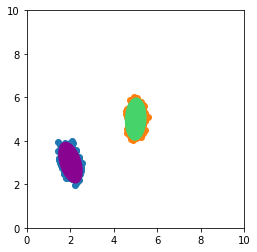

In [103]:
#Ellipse to Gaussian:

x1 = np.array([2,5]).T
y1 = np.array([3,5]).T
rxi1 = np.array([1,1]).T
reta1 = np.array([2,2]).T
alpha1 = np.array([np.random.rand()*360,np.random.rand()*360])
alpha_rad1 = np.array([np.radians(alpha1[0]),np.radians(alpha1[1])]).T

gaussians = ellipseToGaussian(x1,y1,rxi1,reta1,alpha_rad1)

e1 = pat.Ellipse((x1[0],y1[0]), rxi1[0],reta1[0], alpha1[0])
e2 = pat.Ellipse((x1[1],y1[1]), rxi1[1],reta1[1], alpha1[1])

fig = plt.figure(0)

ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

ax.add_artist(e1)
ax.add_artist(e2)
e1.set_facecolor(np.random.rand(3))
e2.set_facecolor(np.random.rand(3))

for tourbillon in gaussians:
    mean = tourbillon[:2]
    C = np.insert(tourbillon[2:], 2, tourbillon[3]).reshape((2,2))
    data = np.random.multivariate_normal(mean, C, 1000)
    plt.scatter(data[:,0],data[:,1])

In [183]:
#Générating dataset using playground

list_mean_gauss, list_covMat_gauss, X, Y, Z = load_playground()

N = 10000
catalogue = generer_catalogue(N, bruit=0,alpha=30, model="follow gradient")

fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')
ax.set_ylim(0, 10)
ax.set_xlim(0, 10)
colors = np.random.rand(N,3)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')
for i in range(10):
    tourbillon1 = plot_tourbillon(catalogue[i,0,:5])
    tourbillon2 = plot_tourbillon(catalogue[i,0,5:])
    ax.add_artist(tourbillon1)
    ax.add_artist(tourbillon2)
    color = colors[i]
    tourbillon1.set_facecolor(color)
    tourbillon2.set_facecolor(color*0.5)

AxisError: axis 1 is out of bounds for array of dimension 1

In [29]:
# save numpy array as txt file

with open('catalogue_obs.txt', 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(catalogue_obs.shape))
    for data_slice in catalogue_obs:
        np.savetxt(outfile, data_slice, fmt='%-7.2f')
        outfile.write('# New slice\n')

## Predictions using stored playground and dataset

In [12]:
#list of parameters to play with

nb_predictions = 10

### Let's start by plotting the playground the data had been generated with

The data had been generated so that the ellipses tend to follow the isolines, a gaussian noise was added to add randomness to trajectories.

Let's plot the playground by loading it with the load_playground function.

Text(0.5, 1.0, 'Playground')

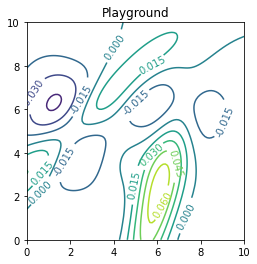

In [5]:
list_mean_gauss, list_covMat_gauss, X, Y, Z = load_playground()

fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')
ax.set_ylim(0, 10)
ax.set_xlim(0, 10)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Playground')

Next we have to load the dataset and generate a list of whirlpool observations

In [166]:
catalogue = load_data('catalogue2.txt')
catalogue_obs = generer_catalogue(30, alpha=30, model="follow gradient")

## Predicted trajectories using AnDa

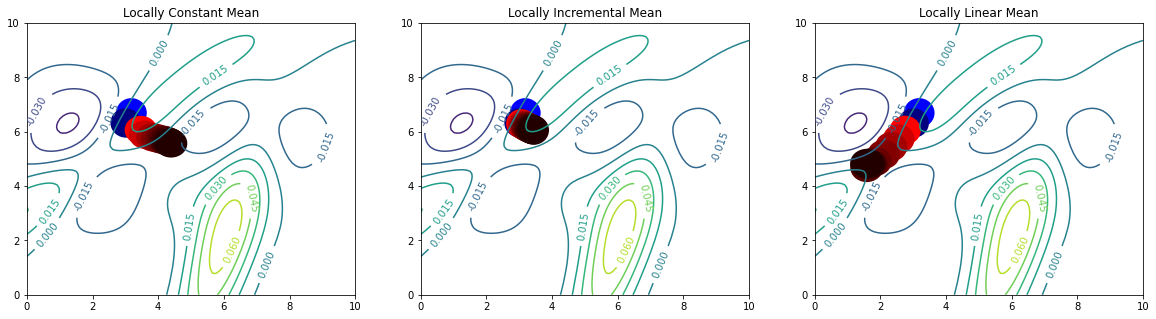

In [175]:
#Predictions for the 11th whirlpool using locally constand mean method of AnDa
tourbillons_suivant1, position_tourbillons_suivant1 = predictions(nb_predictions,catalogue_obs,locally_constant_mean,10)
tourbillons_suivant2, position_tourbillons_suivant2 = predictions(nb_predictions,catalogue_obs,locally_incremental_mean,10)
tourbillons_suivant3, position_tourbillons_suivant3 = predictions(nb_predictions,catalogue_obs,locally_linear_mean,10)
#Plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20, 5))
ax1.set_ylim(0, 10)
ax1.set_xlim(0, 10)
ax1.set_title("Locally Constant Mean")
ax2.set_ylim(0, 10)
ax2.set_xlim(0, 10)
ax2.set_title("Locally Incremental Mean")
ax3.set_ylim(0, 10)
ax3.set_xlim(0, 10)
ax3.set_title("Locally Linear Mean")

CS1 = ax1.contour(X, Y, Z)
ax1.clabel(CS1, inline=1, fontsize=10)
tourbillon_obs_t_1 = plot_tourbillon(catalogue_obs[10,0,:5])
tourbillon_obs_t = plot_tourbillon(catalogue_obs[10,0,5:])
ax1.add_artist(tourbillon_obs_t_1)
ax1.add_artist(tourbillon_obs_t)
tourbillon_obs_t_1.set_facecolor([0,0,1])
tourbillon_obs_t.set_facecolor([0,0,0.5])

CS2 = ax2.contour(X, Y, Z)
ax2.clabel(CS2, inline=1, fontsize=10)
tourbillon_obs_t_1 = plot_tourbillon(catalogue_obs[10,0,:5])
tourbillon_obs_t = plot_tourbillon(catalogue_obs[10,0,5:])
ax2.add_artist(tourbillon_obs_t_1)
ax2.add_artist(tourbillon_obs_t)
tourbillon_obs_t_1.set_facecolor([0,0,1])
tourbillon_obs_t.set_facecolor([0,0,0.5])

CS3 = ax3.contour(X, Y, Z)
ax3.clabel(CS3, inline=1, fontsize=10)
tourbillon_obs_t_1 = plot_tourbillon(catalogue_obs[10,0,:5])
tourbillon_obs_t = plot_tourbillon(catalogue_obs[10,0,5:])
ax3.add_artist(tourbillon_obs_t_1)
ax3.add_artist(tourbillon_obs_t)
tourbillon_obs_t_1.set_facecolor([0,0,1])
tourbillon_obs_t.set_facecolor([0,0,0.5])

color = [1,0,0]
for pred in tourbillons_suivant1:
    ax1.add_artist(pred)
    pred.set_facecolor(color)
    color = [color[0]*0.8,0,0]
color = [1,0,0]
for pred in tourbillons_suivant2:
    ax2.add_artist(pred)
    pred.set_facecolor(color)
    color = [color[0]*0.8,0,0]
color = [1,0,0]  
for pred in tourbillons_suivant3:
    ax3.add_artist(pred)
    pred.set_facecolor(color)
    color = [color[0]*0.8,0,0]

In [176]:
mat_true = list_true_value(nb_predictions,catalogue_obs,bruit=0.2,center=None,alpha=None,model="follow gradient")
mat_prediction1 = list_prediction(nb_predictions, catalogue_obs, locally_constant_mean)
mat_prediction2 = list_prediction(nb_predictions, catalogue_obs, locally_incremental_mean)
mat_prediction3 = list_prediction(nb_predictions, catalogue_obs, locally_linear_mean)

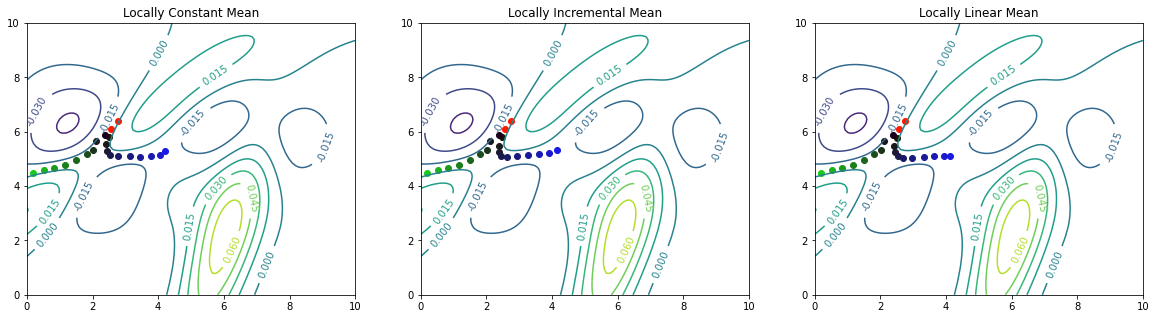

In [92]:
index = 10

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20, 5))
ax1.set_ylim(0, 10)
ax1.set_xlim(0, 10)
ax1.set_title("Locally Constant Mean")
ax2.set_ylim(0, 10)
ax2.set_xlim(0, 10)
ax2.set_title("Locally Incremental Mean")
ax3.set_ylim(0, 10)
ax3.set_xlim(0, 10)
ax3.set_title("Locally Linear Mean")

CS1 = ax1.contour(X, Y, Z)
ax1.clabel(CS1, inline=1, fontsize=10)
CS2 = ax2.contour(X, Y, Z)
ax2.clabel(CS2, inline=1, fontsize=10)
CS3 = ax3.contour(X, Y, Z)
ax3.clabel(CS3, inline=1, fontsize=10)

ax1.scatter(catalogue_obs[index,0,:5][0],catalogue_obs[index,0,:5][1],c=np.array([1,0.1,0]).reshape(1,-1))
ax1.scatter(catalogue_obs[index,0,5:][0],catalogue_obs[index,0,5:][1],c=np.array([1,0.1,0.]).reshape(1,-1))
ax2.scatter(catalogue_obs[index,0,:5][0],catalogue_obs[index,0,:5][1],c=np.array([1,0.1,0]).reshape(1,-1))
ax2.scatter(catalogue_obs[index,0,5:][0],catalogue_obs[index,0,5:][1],c=np.array([1,0.1,0.]).reshape(1,-1))
ax3.scatter(catalogue_obs[index,0,:5][0],catalogue_obs[index,0,:5][1],c=np.array([1,0.1,0]).reshape(1,-1))
ax3.scatter(catalogue_obs[index,0,5:][0],catalogue_obs[index,0,5:][1],c=np.array([1,0.1,0.]).reshape(1,-1))

pred1 = mat_prediction1[index]
pred2 = mat_prediction2[index]
pred3 = mat_prediction3[index]

true = mat_true[index]

i = 0
for mean in pred1:
    ax1.scatter(mean[0],mean[1],c = np.array([0.1,0.1,i/len(pred1)]).reshape(1,-1))
    i+=1
i = 0
for mean in pred2:
    ax2.scatter(mean[0],mean[1],c = np.array([0.1,0.1,i/len(pred2)]).reshape(1,-1))
    i+=1
i = 0
for mean in pred3:
    ax3.scatter(mean[0],mean[1],c = np.array([0.1,0.1,i/len(pred3)]).reshape(1,-1))
    i+=1
i = 0
for mean in true:
    ax1.scatter(mean[0],mean[1],c = np.array([0.1,i/len(pred1),0.1]).reshape(1,-1))
    ax2.scatter(mean[0],mean[1],c = np.array([0.1,i/len(pred2),0.1]).reshape(1,-1))
    ax3.scatter(mean[0],mean[1],c = np.array([0.1,i/len(pred3),0.1]).reshape(1,-1))
    i+=1

In [38]:
list_catalogue = [150, 250, 500, 1000, 1500, 2500, 3000, 4000]
nb_predictions = 10

#Store RMSE score of the k-th whirlpool (dim2), of the i-th dt (dim0) of the j-th catalogue (dim1)

stats_constant = np.zeros((nb_predictions,len(list_catalogue),catalogue_obs.shape[0]))
stats_incremental = np.zeros((nb_predictions,len(list_catalogue),catalogue_obs.shape[0]))
stats_linear = np.zeros((nb_predictions,len(list_catalogue),catalogue_obs.shape[0]))


for j in range(len(list_catalogue)):
    catalogue = generer_catalogue(list_catalogue[j], bruit=0,alpha=30, model="follow gradient")
    print("#########################__Catalogue de ",list_catalogue[j]," élements__#########################" )
    mat_true = list_true_value(nb_predictions,catalogue_obs,bruit=0.2,center=None,alpha=None,model="follow gradient")
    mat_prediction1 = list_prediction(nb_predictions, catalogue_obs, locally_constant_mean)
    mat_prediction2 = list_prediction(nb_predictions, catalogue_obs, locally_incremental_mean)
    mat_prediction3 = list_prediction(nb_predictions, catalogue_obs, locally_linear_mean)
    for i in range(nb_predictions):  
        for k in range(catalogue_obs.shape[0]):
            stats_constant[i,j,k] = AnDA_RMSE(mat_true[k,i,:],mat_prediction1[k,i,:])
            stats_incremental[i,j,k] = AnDA_RMSE(mat_true[k,i,:],mat_prediction2[k,i,:])
            stats_linear[i,j,k] = AnDA_RMSE(mat_true[k,i,:],mat_prediction3[k,i,:])
    


#########################__Catalogue de  150  élements__#########################
#########################__Catalogue de  250  élements__#########################
#########################__Catalogue de  500  élements__#########################
#########################__Catalogue de  1000  élements__#########################
#########################__Catalogue de  1500  élements__#########################
#########################__Catalogue de  2500  élements__#########################
#########################__Catalogue de  3000  élements__#########################
#########################__Catalogue de  4000  élements__#########################


In [16]:
np.savez('predictions_10k', mat_prediction_constant=mat_prediction1, mat_prediction_incremental=mat_prediction2, mat_prediction_linear=mat_prediction3, rmse_constant=rmse_constant, rmse_incremental=rmse_incremental,rmse_linear=rmse_linear)

In [ ]:
npzfile2 = np.load("predictions_10k.npz")
mat_prediction1 = npzfile2['mat_prediction_constant']
mat_prediction2 = npzfile2['mat_prediction_incremental']
mat_prediction3 = npzfile2['mat_prediction_linear']

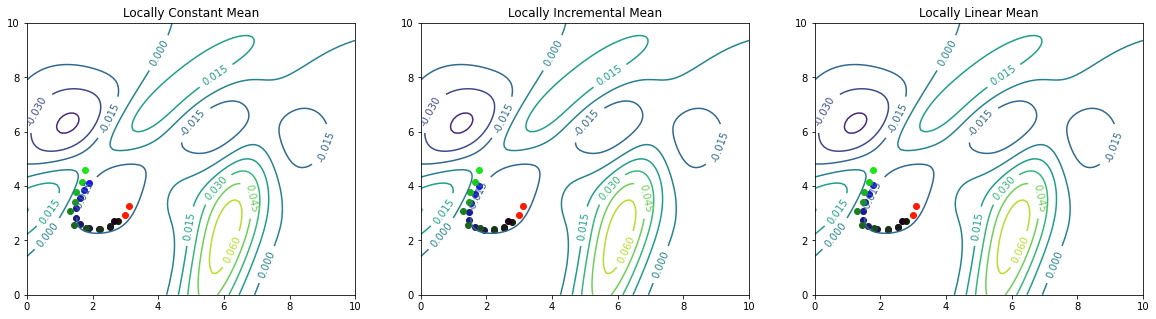

In [91]:
index = 25

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20, 5))
ax1.set_ylim(0, 10)
ax1.set_xlim(0, 10)
ax1.set_title("Locally Constant Mean")
ax2.set_ylim(0, 10)
ax2.set_xlim(0, 10)
ax2.set_title("Locally Incremental Mean")
ax3.set_ylim(0, 10)
ax3.set_xlim(0, 10)
ax3.set_title("Locally Linear Mean")

CS1 = ax1.contour(X, Y, Z)
ax1.clabel(CS1, inline=1, fontsize=10)
CS2 = ax2.contour(X, Y, Z)
ax2.clabel(CS2, inline=1, fontsize=10)
CS3 = ax3.contour(X, Y, Z)
ax3.clabel(CS3, inline=1, fontsize=10)

ax1.scatter(catalogue_obs[index,0,:5][0],catalogue_obs[index,0,:5][1],c=np.array([1,0.1,0]).reshape(1,-1))
ax1.scatter(catalogue_obs[index,0,5:][0],catalogue_obs[index,0,5:][1],c=np.array([1,0.1,0.]).reshape(1,-1))
ax2.scatter(catalogue_obs[index,0,:5][0],catalogue_obs[index,0,:5][1],c=np.array([1,0.1,0]).reshape(1,-1))
ax2.scatter(catalogue_obs[index,0,5:][0],catalogue_obs[index,0,5:][1],c=np.array([1,0.1,0.]).reshape(1,-1))
ax3.scatter(catalogue_obs[index,0,:5][0],catalogue_obs[index,0,:5][1],c=np.array([1,0.1,0]).reshape(1,-1))
ax3.scatter(catalogue_obs[index,0,5:][0],catalogue_obs[index,0,5:][1],c=np.array([1,0.1,0.]).reshape(1,-1))

pred1 = mat_prediction1[index]
pred2 = mat_prediction2[index]
pred3 = mat_prediction3[index]

true = mat_true[index]

i = 0
for mean in pred1:
    ax1.scatter(mean[0],mean[1],c = np.array([0.1,0.1,i/len(pred1)]).reshape(1,-1))
    i+=1
i = 0
for mean in pred2:
    ax2.scatter(mean[0],mean[1],c = np.array([0.1,0.1,i/len(pred2)]).reshape(1,-1))
    i+=1
i = 0
for mean in pred3:
    ax3.scatter(mean[0],mean[1],c = np.array([0.1,0.1,i/len(pred3)]).reshape(1,-1))
    i+=1
i = 0
for mean in true:
    ax1.scatter(mean[0],mean[1],c = np.array([0.1,i/len(pred1),0.1]).reshape(1,-1))
    ax2.scatter(mean[0],mean[1],c = np.array([0.1,i/len(pred2),0.1]).reshape(1,-1))
    ax3.scatter(mean[0],mean[1],c = np.array([0.1,i/len(pred3),0.1]).reshape(1,-1))
    i+=1

In [27]:
print(rmse_constant)
print(rmse_incremental)
print(rmse_linear)

[1.7014289488942949, 1.285931062238213, 1.16951168068665, 0.9568722618809716, 0.8195823788342191, 0.6408290183547694, 0.6166848790869145, 0.6442246304327398, 0.5564469347236792, 0.5600033360885734, 0.6448016294828899]
[1.1186579427720904, 0.9794776788953031, 0.8882877249314165, 0.6395888571295587, 0.6862525515493205, 0.5542952648770745, 0.5096220716792806, 0.4933762662770443, 0.40955712495032565, 0.42162705023534874, 0.5397456625110743]
[1.1620774612930223, 0.9219130167618778, 1.0233387001163965, 0.6667125835970621, 0.6761135422961623, 0.49454994479834125, 0.4619441172694183, 0.42811644141626115, 0.451278214015877, 0.49255340416943183, 0.4573453069109926]


In [34]:
a = np.zeros((nb_predictions, len(list_catalogue),30))
a[0,0,30]

IndexError: index 30 is out of bounds for axis 2 with size 30

In [36]:
catalogue_obs.shape[0]

30

In [39]:
np.savez('Stats', stats_constant=stats_constant, stats_incremental=stats_incremental, stats_linear=stats_linear)

In [47]:
rmse_t_1_constant = stats_constant[0,:,:]
rmse_t_1_incremental = stats_incremental[0,:,:]
rmse_t_1_linear = stats_linear[0,:,:]

In [44]:
rmse_t_1.shape

(8, 30)

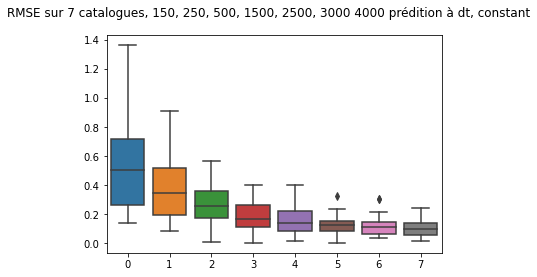

In [65]:
import seaborn as sns
fig, ax = plt.subplots()
fig.suptitle('RMSE sur 7 catalogues, 150, 250, 500, 1500, 2500, 3000 4000 prédition à dt, constant')
ax = sns.boxplot(data=rmse_t_1_constant.T)

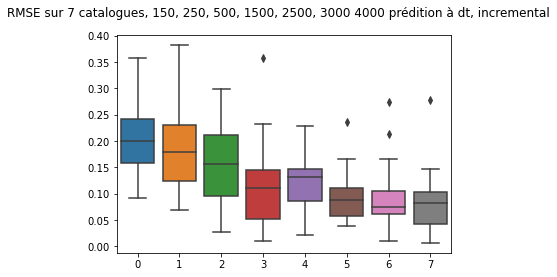

In [70]:
fig, ax = plt.subplots()
fig.suptitle('RMSE sur 7 catalogues, 150, 250, 500, 1500, 2500, 3000 4000 prédition à dt, incremental')
ax = sns.boxplot(data=stats_incremental[0,:,:].T)

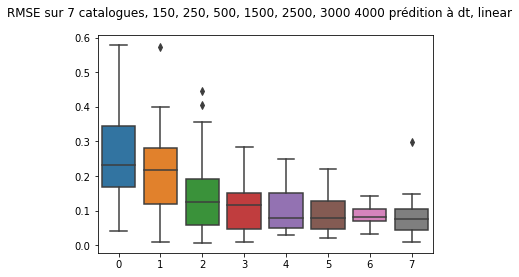

In [73]:
fig, ax = plt.subplots()
fig.suptitle('RMSE sur 7 catalogues, 150, 250, 500, 1500, 2500, 3000 4000 prédition à dt, linear')
ax = sns.boxplot(data=stats_linear[0,:,:].T)

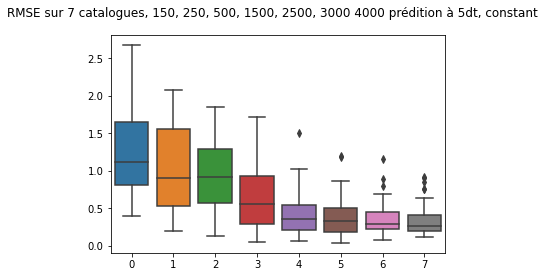

In [72]:
fig, ax = plt.subplots()
fig.suptitle('RMSE sur 7 catalogues, 150, 250, 500, 1500, 2500, 3000 4000 prédition à 5dt, constant')
ax = sns.boxplot(data=stats_constant[4,:,:].T)

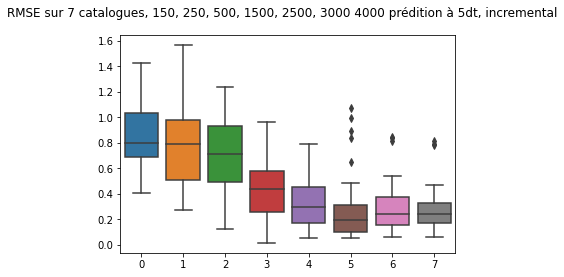

In [74]:
fig, ax = plt.subplots()
fig.suptitle('RMSE sur 7 catalogues, 150, 250, 500, 1500, 2500, 3000 4000 prédition à 5dt, incremental')
ax = sns.boxplot(data=stats_incremental[4,:,:].T)

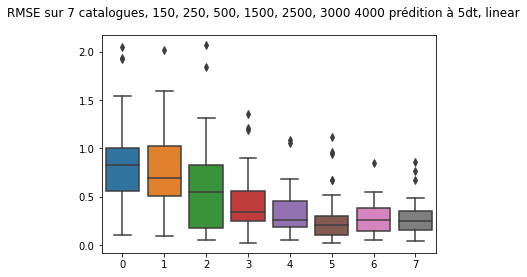

In [75]:
fig, ax = plt.subplots()
fig.suptitle('RMSE sur 7 catalogues, 150, 250, 500, 1500, 2500, 3000 4000 prédition à 5dt, linear')
ax = sns.boxplot(data=stats_linear[4,:,:].T)

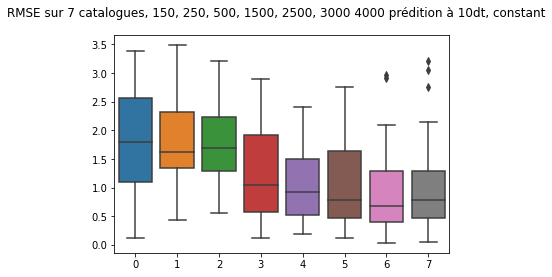

In [77]:
fig, ax = plt.subplots()
fig.suptitle('RMSE sur 7 catalogues, 150, 250, 500, 1500, 2500, 3000 4000 prédition à 10dt, constant')
ax = sns.boxplot(data=stats_constant[9,:,:].T)

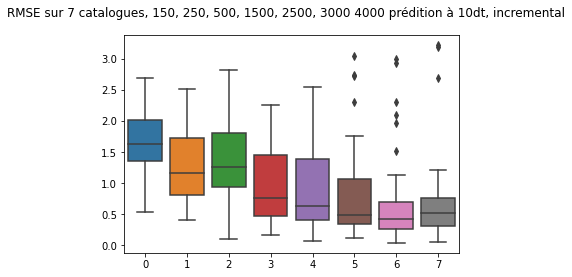

In [78]:
fig, ax = plt.subplots()
fig.suptitle('RMSE sur 7 catalogues, 150, 250, 500, 1500, 2500, 3000 4000 prédition à 10dt, incremental')
ax = sns.boxplot(data=stats_incremental[9,:,:].T)

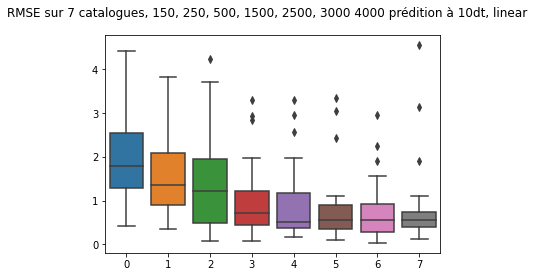

In [79]:
fig, ax = plt.subplots()
fig.suptitle('RMSE sur 7 catalogues, 150, 250, 500, 1500, 2500, 3000 4000 prédition à 10dt, linear')
ax = sns.boxplot(data=stats_linear[9,:,:].T)

In [82]:
stats_constant[0,4]

(10, 8, 30)

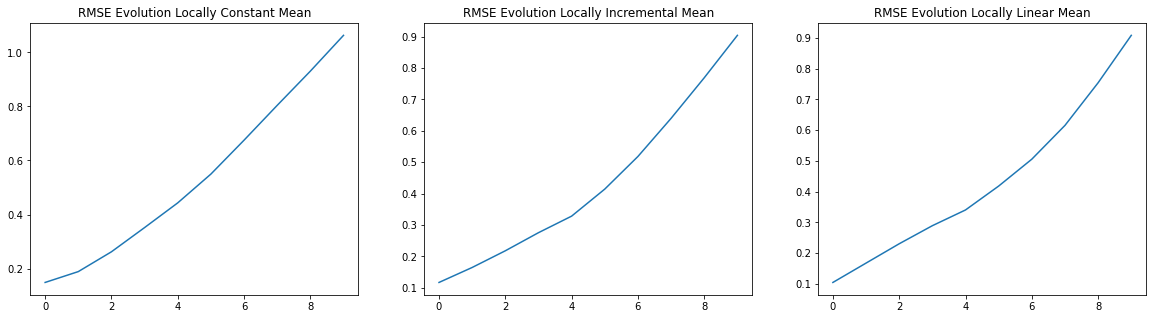

In [83]:
rmse_list_constant = []
rmse_list_incremental = []
rmse_list_linear = []
for i in range(stats_constant.shape[0]):
    rmse_c = np.sum(stats_constant[i,4,:])/30
    rmse_i = np.sum(stats_incremental[i,4,:])/30
    rmse_l = np.sum(stats_linear[i,4,:])/30
    rmse_list_constant.append(rmse_c)
    rmse_list_incremental.append(rmse_i)
    rmse_list_linear.append(rmse_l)
    
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20, 5))

ax1.set_title("RMSE Evolution Locally Constant Mean")
ax2.set_title("RMSE Evolution Locally Incremental Mean")
ax3.set_title("RMSE Evolution Locally Linear Mean")

ax1.plot(rmse_list_constant)
ax2.plot(rmse_list_incremental)
ax3.plot(rmse_list_linear)